In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as PMM
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('kidney_disease.csv')
df.drop('id', axis=1, inplace=True)

In [3]:
df.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'aanemia', 'class']

In [4]:
df['packed_cell_volume'] = pd.to_numeric(df['packed_cell_volume'], errors='coerce')
df['white_blood_cell_count'] = pd.to_numeric(df['white_blood_cell_count'], errors='coerce')
df['red_blood_cell_count'] = pd.to_numeric(df['red_blood_cell_count'], errors='coerce')


In [5]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object']


In [6]:
# Clean categorical columns
df['diabetes_mellitus'].replace(to_replace={'\tno': 'no', '\tyes': 'yes', ' yes': 'yes'}, inplace=True)
df['coronary_artery_disease'] = df['coronary_artery_disease'].replace(to_replace='\tno', value='no')
df['class'] = df['class'].replace(to_replace={'ckd\t': 'ckd', 'notckd': 'not ckd'})

In [7]:
df[cat_cols].isnull().sum()

red_blood_cells            152
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
peda_edema                   1
aanemia                      1
class                        0
dtype: int64

In [8]:
df[num_cols].isnull().sum()

age                         9
blood_pressure             12
specific_gravity           47
albumin                    46
sugar                      49
blood_glucose_random       44
blood_urea                 19
serum_creatinine           17
sodium                     87
potassium                  88
haemoglobin                52
packed_cell_volume         71
white_blood_cell_count    106
red_blood_cell_count      131
dtype: int64

In [9]:
# Encode categorical variables
labelencoder = LabelEncoder()
for column in cat_cols:
    df[column] = labelencoder.fit_transform(df[column].astype(str))

In [10]:
# Initial simple imputation for clustering
simple_imputer = SimpleImputer(strategy='most_frequent')
df[num_cols] = simple_imputer.fit_transform(df[num_cols])
df[cat_cols] = simple_imputer.fit_transform(df[cat_cols])

In [11]:
# Standardize numerical features for clustering
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [12]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df)

In [13]:
# Initialize refined imputers
continuous_imputer = PMM(imputation_order='random', random_state=42)
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [14]:
# Refine imputation within each cluster
for cluster in df['cluster'].unique():
    cluster_indices = df['cluster'] == cluster
    df.loc[cluster_indices, num_cols] = continuous_imputer.fit_transform(df.loc[cluster_indices, num_cols])
    df.loc[cluster_indices, cat_cols] = categorical_imputer.fit_transform(df.loc[cluster_indices, cat_cols])


In [15]:
# Remove the clustering column after imputation
df.drop('cluster', axis=1, inplace=True)

In [16]:
# Check the imputed data
print(df.isna().sum().sort_values(ascending=False))


age                        0
potassium                  0
aanemia                    0
peda_edema                 0
appetite                   0
coronary_artery_disease    0
diabetes_mellitus          0
hypertension               0
red_blood_cell_count       0
white_blood_cell_count     0
packed_cell_volume         0
haemoglobin                0
sodium                     0
blood_pressure             0
serum_creatinine           0
blood_urea                 0
blood_glucose_random       0
bacteria                   0
pus_cell_clumps            0
pus_cell                   0
red_blood_cells            0
sugar                      0
albumin                    0
specific_gravity           0
class                      0
dtype: int64


In [17]:
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,-0.216167,0.254214,0.421486,0.076249,-0.380269,1,2,1,1,-0.283841,...,0.579397,-0.376051,0.380521,2,2,1,0,1,1,0
1,-2.627830,-1.972476,0.421486,2.363728,-0.380269,1,2,1,1,-0.572370,...,-0.154017,-1.069944,0.380521,1,1,1,0,1,1,0
2,0.607327,0.254214,-1.421074,0.838742,2.507853,2,2,1,1,3.676881,...,-1.009667,-0.491700,0.380521,1,2,1,2,1,2,0
3,-0.216167,-0.488016,-2.342354,2.363728,-0.380269,2,0,2,1,-0.336301,...,-0.887431,-0.800097,-1.112845,2,1,1,2,2,2,0
4,-0.039704,0.254214,-1.421074,0.838742,-0.380269,2,2,1,1,-0.480565,...,-0.520724,-0.568799,-0.308725,1,1,1,0,1,1,0


In [18]:
ind_col = [col for col in df.columns if col != 'class']
dep_col = 'class'

X = df[ind_col]
y = df[dep_col]

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of knn

knn_acc = accuracy_score(y_test, knn.predict(X_test))

print(f"Training Accuracy of KNN is {accuracy_score(y_train, knn.predict(X_train))}")
print(f"Test Accuracy of KNN is {knn_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, knn.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, knn.predict(X_test))}")

Training Accuracy of KNN is 0.9892857142857143
Test Accuracy of KNN is 0.9916666666666667 

Confusion Matrix :- 
[[71  1]
 [ 0 48]]

Classification Report :- 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        72
           1       0.98      1.00      0.99        48

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [21]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of decision tree

dtc_acc = accuracy_score(y_test, dtc.predict(X_test))

print(f"Training Accuracy of Decision Tree Classifier is {accuracy_score(y_train, dtc.predict(X_train))}")
print(f"Test Accuracy of Decision Tree Classifier is {dtc_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, dtc.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, dtc.predict(X_test))}")

Training Accuracy of Decision Tree Classifier is 1.0
Test Accuracy of Decision Tree Classifier is 0.925 

Confusion Matrix :- 
[[68  4]
 [ 5 43]]

Classification Report :- 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94        72
           1       0.91      0.90      0.91        48

    accuracy                           0.93       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.93      0.92       120



In [22]:
from sklearn.naive_bayes import GaussianNB

# Build a Gaussian Classifier
nb= GaussianNB()

# Model training
nb.fit(X_train, y_train)

nb_acc = accuracy_score(y_test, nb.predict(X_test))

print(f"Training Accuracy of NB Classifier is {accuracy_score(y_train, dtc.predict(X_train))}")
print(f"Test Accuracy of NB Classifier is {dtc_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, dtc.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, dtc.predict(X_test))}")

Training Accuracy of NB Classifier is 1.0
Test Accuracy of NB Classifier is 0.925 

Confusion Matrix :- 
[[68  4]
 [ 5 43]]

Classification Report :- 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94        72
           1       0.91      0.90      0.91        48

    accuracy                           0.93       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.93      0.92       120



In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define a pipeline with preprocessing steps and Perceptron classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ('perceptron', Perceptron(alpha=0.001, max_iter=1000))  # Set hyperparameters to the previously grid-searched values
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Calculate the accuracy of the pipeline on the test set
perceptron_acc = accuracy_score(y_test, pipeline.predict(X_test))

# Print training and test accuracy of the pipeline
print(f"Training Accuracy of the Perceptron Pipeline is {accuracy_score(y_train, pipeline.predict(X_train))}")
print(f"Test Accuracy of the Perceptron Pipeline is {perceptron_acc} \n")

# Print confusion matrix
print(f"Confusion Matrix :- \n{confusion_matrix(y_test, pipeline.predict(X_test))}\n")

# Print classification report
print(f"Classification Report :- \n {classification_report(y_test, pipeline.predict(X_test))}")

Training Accuracy of the Perceptron Pipeline is 1.0
Test Accuracy of the Perceptron Pipeline is 0.975 

Confusion Matrix :- 
[[72  0]
 [ 3 45]]

Classification Report :- 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.94      0.97        48

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120



In [24]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
log_reg_model = LogisticRegression()

# Train the Logistic Regression model
log_reg_model.fit(X_train, y_train)

# Calculate the accuracy of the Logistic Regression model on the test set
log_reg_acc = accuracy_score(y_test, log_reg_model.predict(X_test))

# Print training and test accuracy
print(f"Training Accuracy of Logistic Regression Classifier is {accuracy_score(y_train, log_reg_model.predict(X_train))}")
print(f"Test Accuracy of Logistic Regression Classifier is {log_reg_acc} \n")

# Print confusion matrix
print(f"Confusion Matrix :- \n{confusion_matrix(y_test, log_reg_model.predict(X_test))}\n")

# Print classification report
print(f"Classification Report :- \n {classification_report(y_test, log_reg_model.predict(X_test))}")

Training Accuracy of Logistic Regression Classifier is 1.0
Test Accuracy of Logistic Regression Classifier is 1.0 

Confusion Matrix :- 
[[72  0]
 [ 0 48]]

Classification Report :- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        48

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



In [25]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the Random Forest model
rf_model = RandomForestClassifier()

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Calculate the accuracy of the Random Forest model on the test set
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))

# Print training and test accuracy
print(f"Training Accuracy of Random Forest Classifier is {accuracy_score(y_train, rf_model.predict(X_train))}")
print(f"Test Accuracy of Random Forest Classifier is {rf_acc} \n")

# Print confusion matrix
print(f"Confusion Matrix :- \n{confusion_matrix(y_test, rf_model.predict(X_test))}\n")

# Print classification report
print(f"Classification Report :- \n {classification_report(y_test, rf_model.predict(X_test))}")

Training Accuracy of Random Forest Classifier is 1.0
Test Accuracy of Random Forest Classifier is 1.0 

Confusion Matrix :- 
[[72  0]
 [ 0 48]]

Classification Report :- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        48

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the base classifier (decision tree)
base_classifier = DecisionTreeClassifier()

# Define the bagging classifier with base classifier
btm = BaggingClassifier( n_estimators=10, random_state=42)

# Train the Bagging Tree Model
btm.fit(X_train, y_train)

# Make predictions on the test set
predictions = btm.predict(X_test)

# Evaluate the model
btm_acc= accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

# Print the evaluation metrics
print(f"Training Accuracy of BTM: {accuracy_score(y_train, btm.predict(X_train))}")
print(f"Test Accuracy of BTM: {btm_acc}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{class_report}\n")

Training Accuracy of BTM: 1.0
Test Accuracy of BTM: 0.9666666666666667

Confusion Matrix:
[[72  0]
 [ 4 44]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.92      0.96        48

    accuracy                           0.97       120
   macro avg       0.97      0.96      0.96       120
weighted avg       0.97      0.97      0.97       120




In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create a Random Tree classifier
rt_classifier = RandomForestClassifier(n_estimators=1)

# Train the classifier
rt_classifier.fit(X_train, y_train)

# Predict on the test set
rt_predictions = rt_classifier.predict(X_test)

# Evaluate the classifier
rt_accuracy = accuracy_score(y_test, rt_predictions)
rt_confusion_matrix = confusion_matrix(y_test, rt_predictions)
rt_classification_report = classification_report(y_test, rt_predictions)

print("Random Tree Classifier:")
print(f"Accuracy: {rt_accuracy}")
print("Confusion Matrix:")
print(rt_confusion_matrix)
print("Classification Report:")
print(rt_classification_report)

Random Tree Classifier:
Accuracy: 0.975
Confusion Matrix:
[[69  3]
 [ 0 48]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        72
           1       0.94      1.00      0.97        48

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


nn = MLPClassifier(hidden_layer_sizes=(2,2), max_iter=10000, random_state=10,learning_rate_init=0.03)

# Train the Neural Network model
nn.fit(X_train, y_train)

# Make predictions on the test set
predictions = nn.predict(X_test)

# Evaluate the model
nn_mlp_acc = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

# Print the evaluation metrics
print(f"Training Accuracy of NN: {accuracy_score(y_train, nn.predict(X_train))}")
print(f"Test Accuracy of NN: {nn_mlp_acc}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{class_report}\n")

Training Accuracy of NN: 1.0
Test Accuracy of NN: 0.9916666666666667

Confusion Matrix:
[[71  1]
 [ 0 48]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        72
           1       0.98      1.00      0.99        48

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120




In [29]:
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,-0.216167,0.254214,0.421486,0.076249,-0.380269,1,2,1,1,-0.283841,...,0.579397,-0.376051,0.380521,2,2,1,0,1,1,0
1,-2.627830,-1.972476,0.421486,2.363728,-0.380269,1,2,1,1,-0.572370,...,-0.154017,-1.069944,0.380521,1,1,1,0,1,1,0
2,0.607327,0.254214,-1.421074,0.838742,2.507853,2,2,1,1,3.676881,...,-1.009667,-0.491700,0.380521,1,2,1,2,1,2,0
3,-0.216167,-0.488016,-2.342354,2.363728,-0.380269,2,0,2,1,-0.336301,...,-0.887431,-0.800097,-1.112845,2,1,1,2,2,2,0
4,-0.039704,0.254214,-1.421074,0.838742,-0.380269,2,2,1,1,-0.480565,...,-0.520724,-0.568799,-0.308725,1,1,1,0,1,1,0


In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters found by the grid search
best_params = grid_search.best_params_

# Instantiate the SVM model with the best parameters
best_svm_model = SVC(**best_params)

# Train the SVM model with the best parameters
best_svm_model.fit(X_train, y_train)

# Calculate the accuracy of the SVM model with the best parameters on the test set
svm_acc = accuracy_score(y_test, best_svm_model.predict(X_test))

# Print training and test accuracy
print(f"Training Accuracy of SVM Classifier with best parameters is {accuracy_score(y_train, best_svm_model.predict(X_train))}")
print(f"Test Accuracy of SVM Classifier with best parameters is {svm_acc} \n")

# Print confusion matrix
print(f"Confusion Matrix with best parameters :- \n{confusion_matrix(y_test, best_svm_model.predict(X_test))}\n")

# Print classification report
print(f"Classification Report with best parameters :- \n {classification_report(y_test, best_svm_model.predict(X_test))}")


Training Accuracy of SVM Classifier with best parameters is 1.0
Test Accuracy of SVM Classifier with best parameters is 1.0 

Confusion Matrix with best parameters :- 
[[72  0]
 [ 0 48]]

Classification Report with best parameters :- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        48

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



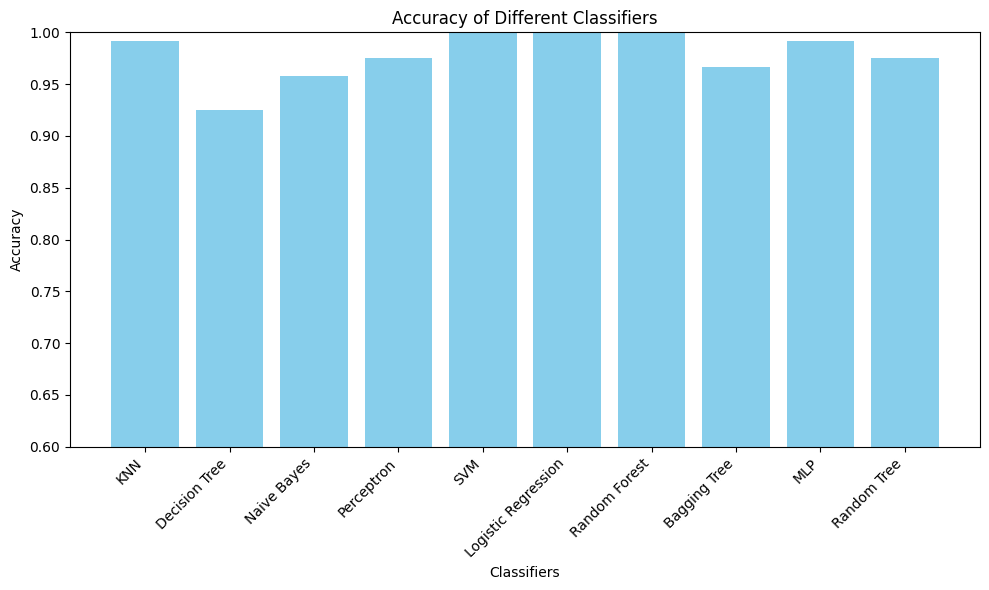

In [31]:
import matplotlib.pyplot as plt

# Define the accuracies
accuracies = [knn_acc, dtc_acc, nb_acc, perceptron_acc, svm_acc, log_reg_acc, rf_acc, btm_acc, nn_mlp_acc, rt_accuracy]
labels = ['KNN', 'Decision Tree', 'Naive Bayes', 'Perceptron', 'SVM', 'Logistic Regression', 'Random Forest', 'Bagging Tree', 'MLP', 'Random Tree']

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color='skyblue')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifiers')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.6, 1)  # Set y-axis limit to range between 0.6 and 1
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

In [33]:
df = pd.read_csv('kidney_disease.csv')
df.drop('id', axis=1, inplace=True)

In [34]:
df.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'aanemia', 'class']

In [35]:
df['packed_cell_volume'] = pd.to_numeric(df['packed_cell_volume'], errors='coerce')
df['white_blood_cell_count'] = pd.to_numeric(df['white_blood_cell_count'], errors='coerce')
df['red_blood_cell_count'] = pd.to_numeric(df['red_blood_cell_count'], errors='coerce')


In [36]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object']


In [37]:
# Clean categorical columns
df['diabetes_mellitus'].replace(to_replace={'\tno': 'no', '\tyes': 'yes', ' yes': 'yes'}, inplace=True)
df['coronary_artery_disease'] = df['coronary_artery_disease'].replace(to_replace='\tno', value='no')
df['class'] = df['class'].replace(to_replace={'ckd\t': 'ckd', 'notckd': 'not ckd'})

In [38]:
# Encode categorical variables
labelencoder = LabelEncoder()
for column in cat_cols:
    df[column] = labelencoder.fit_transform(df[column].astype(str))

In [39]:
# Initial simple imputation for clustering
simple_imputer = SimpleImputer(strategy='most_frequent')
df[num_cols] = simple_imputer.fit_transform(df[num_cols])
df[cat_cols] = simple_imputer.fit_transform(df[cat_cols])

In [40]:
# Standardize numerical features for clustering
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [41]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df)

In [42]:
# Initialize refined imputers
continuous_imputer = PMM(imputation_order='random', random_state=42)
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [43]:
# Refine imputation within each cluster
for cluster in df['cluster'].unique():
    cluster_indices = df['cluster'] == cluster
    df.loc[cluster_indices, num_cols] = continuous_imputer.fit_transform(df.loc[cluster_indices, num_cols])
    df.loc[cluster_indices, cat_cols] = categorical_imputer.fit_transform(df.loc[cluster_indices, cat_cols])


In [44]:
# Remove the clustering column after imputation
df.drop('cluster', axis=1, inplace=True)

In [45]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train XGBoost model to perform feature selection
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:


# Use feature importance for feature selection
feature_importance = xgb_model.feature_importances_
feature_selection_model = SelectFromModel(xgb_model, threshold='median')
feature_selection_model.fit(X_train, y_train)



SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                threshold='median')

In [47]:
# Add the following lines to print selected columns
selected_features_mask = feature_selection_model.get_support()
selected_columns = X_train.columns[selected_features_mask]
print("Selected columns by XGBoost feature selection:")
print(selected_columns)

Selected columns by XGBoost feature selection:
Index(['blood_pressure', 'specific_gravity', 'albumin', 'red_blood_cells',
       'blood_urea', 'serum_creatinine', 'sodium', 'haemoglobin',
       'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
       'diabetes_mellitus'],
      dtype='object')


In [48]:
# Select features
X_train_selected = feature_selection_model.transform(X_train)
X_test_selected = feature_selection_model.transform(X_test)

In [49]:
 #Retrain models with selected features
# KNN
knn = KNeighborsClassifier(3)
knn.fit(X_train_selected, y_train)

KNeighborsClassifier(n_neighbors=3)

In [50]:
# Decision Tree
dtc = DecisionTreeClassifier()
dtc.fit(X_train_selected, y_train)

DecisionTreeClassifier()

In [51]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_selected, y_train)

GaussianNB()

In [52]:
# Perceptron
perceptron = Perceptron(alpha=0.001, max_iter=1000)
perceptron.fit(X_train_selected, y_train)

Perceptron(alpha=0.001)

In [53]:
# SVM
svm_model = SVC()
svm_model.fit(X_train_selected, y_train)

SVC()

In [54]:
# Logistic Regression
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_selected, y_train)

LogisticRegression()

In [55]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_selected, y_train)

RandomForestClassifier()

In [56]:
# Bagging Tree
base_classifier = DecisionTreeClassifier()
btm = BaggingClassifier( n_estimators=10, random_state=42)
btm.fit(X_train_selected, y_train)

BaggingClassifier(random_state=42)

In [57]:
# MLP
nn = MLPClassifier(hidden_layer_sizes=(37,36), max_iter=10000, random_state=42,learning_rate_init=0.01)
nn.fit(X_train_selected, y_train)

MLPClassifier(hidden_layer_sizes=(37, 36), learning_rate_init=0.01,
              max_iter=10000, random_state=42)

In [58]:
# Random Tree
rt_classifier = RandomForestClassifier(n_estimators=1)
rt_classifier.fit(X_train_selected, y_train)

RandomForestClassifier(n_estimators=1)

In [59]:
# Evaluate model performance
models = {
    'KNN': knn,
    'Decision Tree': dtc,
    'Naive Bayes': nb,
    'Perceptron': perceptron,
    'SVM': svm_model,
    'Logistic Regression': log_reg_model,
    'Random Forest': rf_model,
    'Bagging Tree': btm,
    'MLP': nn,
    'Random Tree': rt_classifier
}

In [60]:
accuracies = {}
confusion_matrices = {}
classification_reports = {}
specificities = {}
sensitivities = {}
kappa_scores = {}

In [61]:
# Assuming 'ckd' is encoded as 1
pos_label = 1

In [62]:
# Assuming feature_selection_model and X_train are already defined
selected_features_mask = feature_selection_model.get_support()
selected_columns = X_train.columns[selected_features_mask]
print("Selected columns by XGBoost feature selection:")
print(selected_columns)

Selected columns by XGBoost feature selection:
Index(['blood_pressure', 'specific_gravity', 'albumin', 'red_blood_cells',
       'blood_urea', 'serum_creatinine', 'sodium', 'haemoglobin',
       'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
       'diabetes_mellitus'],
      dtype='object')


In [63]:
for name, model in models.items():
    # Predictions
    y_pred = model.predict(X_test_selected)
    
    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Sensitivity (Recall)
    sensitivity = recall_score(y_test, y_pred, pos_label=pos_label)
    
    # Specificity
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    
    # Store metrics
    accuracies[name] = acc
    confusion_matrices[name] = conf_matrix
    classification_reports[name] = class_report
    specificities[name] = specificity
    sensitivities[name] = sensitivity
    kappa_scores[name] = kappa

In [64]:
# Print model performance
for name in models.keys():
    print(f"{name} Accuracy: {accuracies[name]}")
    print(f"Confusion Matrix:\n{confusion_matrices[name]}")
    print(f"Classification Report:\n{classification_reports[name]}")
    print(f"Sensitivity (Recall): {sensitivities[name]}")
    print(f"Specificity: {specificities[name]}")
    print(f"Kappa Score: {kappa_scores[name]}")
    print("-----------------------")

# Plot comparison graph for Accuracy, Sensitivity, Specificity, and Kappa Score
metrics_df = pd.DataFrame({
    'Model': models.keys(),
    'Accuracy': accuracies.values(),
    'Sensitivity': sensitivities.values(),
    'Specificity': specificities.values(),
    'Kappa Score': kappa_scores.values()
})

KNN Accuracy: 0.9916666666666667
Confusion Matrix:
[[75  1]
 [ 0 44]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

Sensitivity (Recall): 1.0
Specificity: 0.9868421052631579
Kappa Score: 0.9821428571428571
-----------------------
Decision Tree Accuracy: 0.9916666666666667
Confusion Matrix:
[[75  1]
 [ 0 44]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

Sensitivity (Recall): 1.0
Specificit

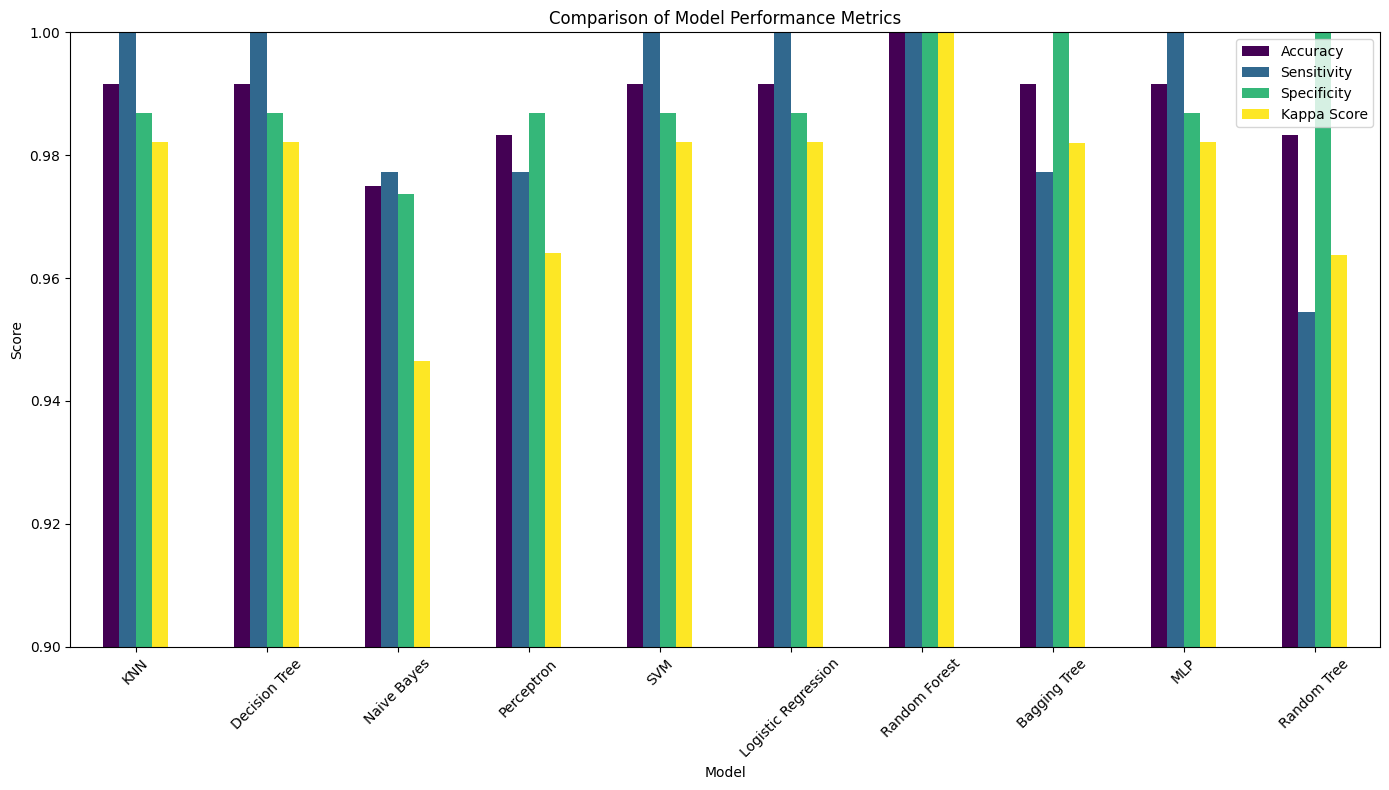

In [65]:
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.ylim(0.90, 1)
plt.tight_layout()
plt.show()

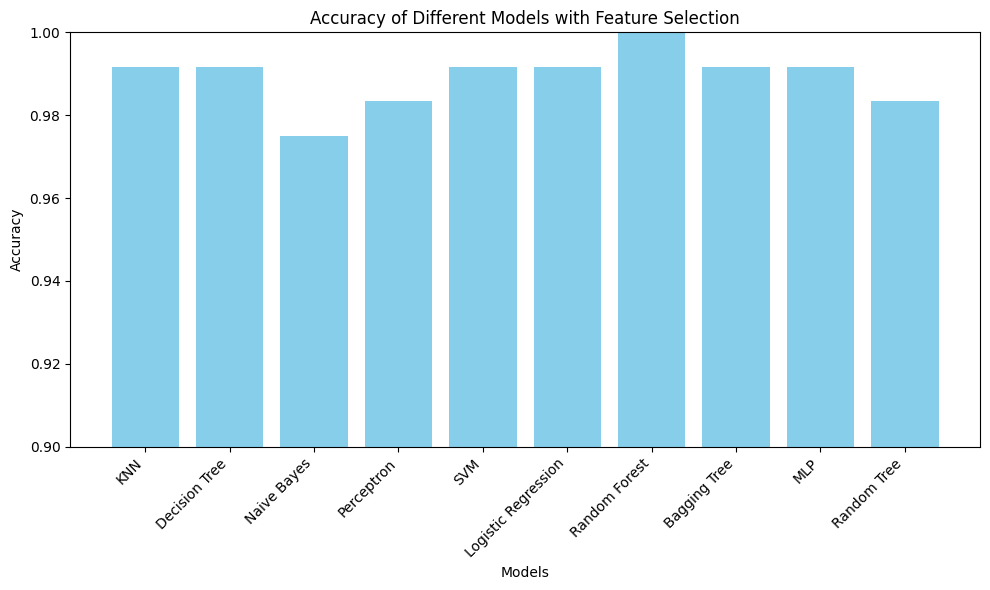

In [66]:
# Plot comparison graph
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models with Feature Selection')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.90, 1)  # Set y-axis limit to range between 0.6 and 1
plt.tight_layout()
plt.show()

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)

# accuracy score, confusion matrix and classification report of knn

knn_acc = accuracy_score(y_test, knn.predict(X_test))

print(f"Training Accuracy of KNN is {accuracy_score(y_train, knn.predict(X_train))}")
print(f"Test Accuracy of KNN is {knn_acc} \n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, knn.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, knn.predict(X_test))}")

Training Accuracy of KNN is 0.9857142857142858
Test Accuracy of KNN is 0.975 

Confusion Matrix :- 
[[73  3]
 [ 0 44]]

Classification Report :- 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        76
           1       0.94      1.00      0.97        44

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



In [68]:

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters found by the grid search
best_params = grid_search.best_params_

# Instantiate the SVM model with the best parameters
best_svm_model = SVC(**best_params)

# Train the SVM model with the best parameters
best_svm_model.fit(X_train, y_train)

# Calculate the accuracy of the SVM model with the best parameters on the test set
svm_acc = accuracy_score(y_test, best_svm_model.predict(X_test))

# Print training and test accuracy
print(f"Training Accuracy of SVM Classifier with best parameters is {accuracy_score(y_train, best_svm_model.predict(X_train))}")
print(f"Test Accuracy of SVM Classifier with best parameters is {svm_acc} \n")

# Print confusion matrix
print(f"Confusion Matrix with best parameters :- \n{confusion_matrix(y_test, best_svm_model.predict(X_test))}\n")

# Print classification report
print(f"Classification Report with best parameters :- \n {classification_report(y_test, best_svm_model.predict(X_test))}")

Training Accuracy of SVM Classifier with best parameters is 0.9964285714285714
Test Accuracy of SVM Classifier with best parameters is 0.9916666666666667 

Confusion Matrix with best parameters :- 
[[75  1]
 [ 0 44]]

Classification Report with best parameters :- 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [69]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


nn = MLPClassifier(hidden_layer_sizes=(2,2), max_iter=10000, random_state=10,learning_rate_init=0.03)

# Train the Neural Network model
nn.fit(X_train, y_train)

# Make predictions on the test set
predictions = nn.predict(X_test)

# Evaluate the model
nn_mlp_acc = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

# Print the evaluation metrics
print(f"Training Accuracy of NN: {accuracy_score(y_train, nn.predict(X_train))}")
print(f"Test Accuracy of NN: {nn_mlp_acc}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{class_report}\n")

Training Accuracy of NN: 1.0
Test Accuracy of NN: 0.9916666666666667

Confusion Matrix:
[[75  1]
 [ 0 44]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120




In [70]:
for name, model in models.items():
    # Predictions
    y_pred = model.predict(X_test_selected)
    
    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Ensure the confusion matrix is correctly computed
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Store metrics
    accuracies[name] = acc
    confusion_matrices[name] = conf_matrix

# Print confusion matrices and accuracies
for name in models.keys():
    print(f"{name} Accuracy: {accuracies[name]}")
    print(f"{name} Confusion Matrix:\n{confusion_matrices[name]}")
    print("-----------------------")


KNN Accuracy: 0.9916666666666667
KNN Confusion Matrix:
[[75  1]
 [ 0 44]]
-----------------------
Decision Tree Accuracy: 0.9916666666666667
Decision Tree Confusion Matrix:
[[75  1]
 [ 0 44]]
-----------------------
Naive Bayes Accuracy: 0.975
Naive Bayes Confusion Matrix:
[[74  2]
 [ 1 43]]
-----------------------
Perceptron Accuracy: 0.9833333333333333
Perceptron Confusion Matrix:
[[75  1]
 [ 1 43]]
-----------------------
SVM Accuracy: 0.9916666666666667
SVM Confusion Matrix:
[[75  1]
 [ 0 44]]
-----------------------
Logistic Regression Accuracy: 0.9916666666666667
Logistic Regression Confusion Matrix:
[[75  1]
 [ 0 44]]
-----------------------
Random Forest Accuracy: 1.0
Random Forest Confusion Matrix:
[[76  0]
 [ 0 44]]
-----------------------
Bagging Tree Accuracy: 0.9916666666666667
Bagging Tree Confusion Matrix:
[[76  0]
 [ 1 43]]
-----------------------
MLP Accuracy: 0.9916666666666667
MLP Confusion Matrix:
[[75  1]
 [ 0 44]]
-----------------------
Random Tree Accuracy: 0.98